<a href="https://colab.research.google.com/github/mrouault/mc-gibbs/blob/main/mala_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Packages**

In [264]:
!pip install numpyro
%matplotlib inline
from typing import Callable
import matplotlib.pyplot as plt
from jax import numpy as jnp
from jax import scipy
from jax import random, Array, jit, vmap, grad
from jax.tree_util import Partial as partial
from jax.lax import fori_loop, cond, dynamic_slice
import numpyro
import optax

**Seed**

In [265]:
key = random.PRNGKey(0)


# **Target measure (Gibbs)**



In [336]:
class gibbs(numpyro.distributions.Distribution) :

    def __init__(self, d, N, K, V, beta_N) :

        self.N = N
        self.K = K
        self.V = V
        self.d = d
        self.beta_N = beta_N
        event_shape = (N*d, )
        super(gibbs, self).__init__(event_shape = event_shape)

    def log_prob(self, value) :

        #value = (x_1, \dots, x_N)

        value_shape = value.shape #should be (1, N*d)
        X = jnp.array(value.reshape(self.N, self.d))
        index = jnp.array([k for k in range(self.N)])

        k_inter = lambda j, k : self.K(X[j, :], X[k, :])
        pair_j = lambda j : jit(vmap(partial(k_inter, j)))(index).sum()
        pair_inter = - self.beta_N * jit(pair_j)(index).sum() / (2*self.N**2)

        v_inter = lambda j : self.V(X[j, :])
        exter_V =  - self.beta_N * jit(v_inter)(index).sum() / N

        return pair_inter + exter_V




In [267]:
def V(x) :

    xnorm = jnp.linalg.norm(x)
    v = -0.5 + 0.5* xnorm**2
    outlier = xnorm > 1
    res = cond(outlier,
               lambda _ : np.inf,
               lambda _ : v,
               None)
    return  res

def K(x, y, eps = 1e-5) :

    return - jnp.log(jnp.linalg.norm(x-y)**2 + eps**2)
    #return (jnp.linalg.norm(x-y)**2 + eps**2)**(-(d-2)/2)

In [268]:
d = 2
N = 100 #la dim est Nd (on concatène)
beta_N = 2*N**2
target = gibbs(d, N, K, V, beta_N)

In [269]:
key_sample = random.split(key)
mvn = numpyro.distributions.MultivariateNormal(loc=jnp.zeros(d*N), covariance_matrix= jnp.eye(d*N))
mvn_samples = mvn.sample(key, (1,))
target.log_prob(mvn_samples)

Array(-inf, dtype=float32)

# **Basic MALA**

In [270]:
def mala(key: Array,
         start_sample: Array,
         log_prob_target: Callable[[jnp.ndarray], jnp.ndarray],
         n_iter: int,
         step_size: float) -> jnp.ndarray:
    '''
    This function implements MALA sampler.
    :param key: PRNGArray specifying the key that is used for the random numbers
    :param start_sample: Array with the first element
    :param log_prob_target: Function that calculates the log probability of the target distribution at a given point.
    :param n_iter: int The number of steps of the chain.
    :param step_size: The step size (gamma above) for the Langevin kernel.
    :return: The last sample of the chain
    '''
    val = (start_sample, key)
    #you need to define the gradient of the log_prob_target parameter
    grad_logpdf = grad(lambda x: log_prob_target(x))

    def mh_step(i, val):

        sample, key = val
        key, subkey_u, subkey_sample = random.split(key, 3)
        #Sample the langevin kernel
        noise = random.normal(subkey_sample, (sample.shape[-1],))
        next = sample + step_size * grad_logpdf(sample) \
               + jnp.sqrt(2 * step_size) * noise
        #Compute the log acceptance ratio
        fwd_ker_logprob = - (noise ** 2).sum() / 2
        bwd_ker_logprob = - ((sample - next - step_size * grad_logpdf(next))**2).sum() / (4 * step_size)
        log_ratio = log_prob_target(next) + bwd_ker_logprob - log_prob_target(sample) - fwd_ker_logprob

        log_u = jnp.log(random.uniform(subkey_u))
        accept = log_ratio > log_u
        x = cond(accept,
                 lambda _: next,
                 lambda _: sample,
                 None)
        return (x, key)

    sample, k = fori_loop(0,
                          n_iter,
                          body_fun=mh_step,
                          init_val=val)
    return sample

In [271]:
key, _ = random.split(key, 2)
d = 2
N = 100
beta_N = N**2
target = gibbs(d, N, K, V, beta_N)
mvn = numpyro.distributions.MultivariateNormal(loc=jnp.zeros(d*N), covariance_matrix= 0.1*jnp.eye(d*N))
start_sample = mvn.sample(key, (1, ))

In [272]:
sample_mala = jit(vmap(partial(mala,
                               log_prob_target = target.log_prob,
                               n_iter = 1_000,
                               step_size = 0.05)))(random.split(key, 1), start_sample)
sample_mala_reshaped = sample_mala.reshape(N, d).T

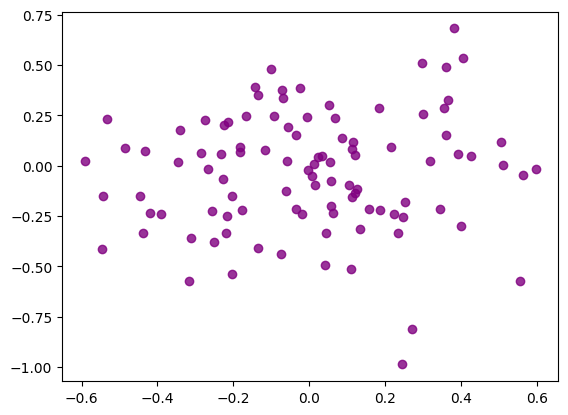

In [273]:
fig, axes = plt.subplots()
axes.scatter(*sample_mala_reshaped, alpha = 0.8, color = "purple")

# **Tamed MALA**

In [274]:
def mala_tamed(key: Array,
         start_sample: Array,
         log_prob_target: Callable[[jnp.ndarray], jnp.ndarray],
         n_iter: int,
         step_size: float,) -> jnp.ndarray:
    '''
    This function implements MALA sampler.
    :param key: PRNGArray specifying the key that is used for the random numbers
    :param start_sample: Array with the first element
    :param log_prob_target: Function that calculates the log probability of the target distribution at a given point.
    :param n_iter: int The number of steps of the chain.
    :param step_size: The step size (gamma above) for the Langevin kernel.
    :return: The last sample of the chain
    '''
    val = (start_sample, key)
    #you need to define the gradient of the log_prob_target parameter
    grad_logpdf = grad(lambda x: log_prob_target(x))

    def mh_step(i, val):

        sample, key = val
        key, subkey_u, subkey_sample = random.split(key, 3)
        #Sample the langevin kernel
        noise = random.normal(subkey_sample, (sample.shape[-1],))
        grad_sample = grad_logpdf(sample)
        next = sample + step_size * grad_sample / (1+step_size *jnp.linalg.norm(grad_sample)) \
               + jnp.sqrt(2 * step_size) * noise
        #Compute the log acceptance ratio
        fwd_ker_logprob = - (noise ** 2).sum() / 2
        grad_next = grad_logpdf(next)
        bwd_ker_logprob = - ((sample - next - step_size * grad_next/(1+step_size * jnp.linalg.norm(grad_next)))**2).sum() / (4 * step_size)
        log_ratio = log_prob_target(next) + bwd_ker_logprob - log_prob_target(sample) - fwd_ker_logprob

        log_u = jnp.log(random.uniform(subkey_u))
        accept = log_ratio > log_u
        x = cond(accept,
                 lambda _: next,
                 lambda _: sample,
                 None)
        return (x, key)

    sample, k = fori_loop(0,
                          n_iter,
                          body_fun=mh_step,
                          init_val=val)
    return sample

In [275]:
key, _ = random.split(key, 2)
d = 2
N = 500
beta_N = N**2
target = gibbs(d, N, K, V, beta_N)
mvn = numpyro.distributions.MultivariateNormal(loc=jnp.zeros(d*N), covariance_matrix= jnp.eye(d*N))
start_sample = mvn.sample(key, (1, ))

In [276]:
sample_mala_tamed = jit(vmap(partial(mala_tamed,
                               log_prob_target = target.log_prob,
                               n_iter = 10_000,
                               step_size = 0.1)))(random.split(key, 1), start_sample)
sample_mala_tamed_reshaped = sample_mala_tamed.reshape(N, d).T

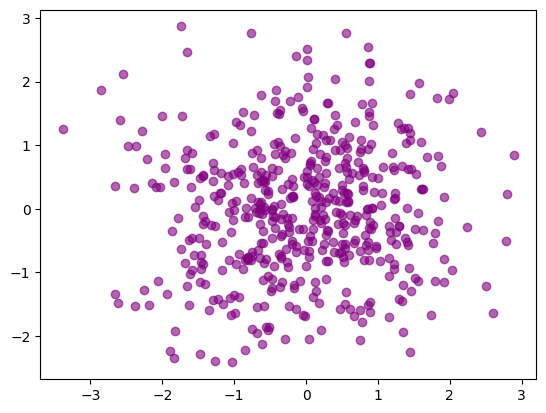

In [277]:
fig, axes = plt.subplots()
axes.scatter(*sample_mala_tamed_reshaped, alpha = 0.6, color = "purple")

# **MALA Tamed Particle-wise**

In [278]:
def mala_tamed_pwise(key: Array,
         start_sample: Array,
         N : int,
         d : int,
         log_prob_target: Callable[[jnp.ndarray], jnp.ndarray],
         n_iter: int,
         step_size: float,) -> jnp.ndarray:
    '''
    This function implements MALA sampler.
    :param key: PRNGArray specifying the key that is used for the random numbers
    :param start_sample: Array with the first element
    :param log_prob_target: Function that calculates the log probability of the target distribution at a given point.
    :param n_iter: int The number of steps of the chain.
    :param step_size: The step size (gamma above) for the Langevin kernel.
    :return: The last sample of the chain
    '''
    val = (start_sample, key)
    #you need to define the gradient of the log_prob_target parameter
    grad_logpdf = grad(lambda x: log_prob_target(x))

    def mh_step(i, val):

        sample, key = val
        key, subkey_u, subkey_sample = random.split(key, 3)
        #Sample the langevin kernel
        noise = random.normal(subkey_sample, (sample.shape[-1],))
        grad_sample = grad_logpdf(sample)
        grad_sample_reshaped = grad_sample.reshape(N, d)
        norm_grad_pwise = jnp.array([jnp.linalg.norm(grad_sample_reshaped[k, :])*jnp.ones(d) for k in range(N)])

        next = sample + step_size * grad_sample / (jnp.ones_like(sample)+step_size * norm_grad_pwise.reshape(d*N)) \
               + jnp.sqrt(2 * step_size) * noise
        #Compute the log acceptance ratio
        fwd_ker_logprob = - (noise ** 2).sum() / 2
        grad_next = grad_logpdf(next)
        grad_next_reshaped = grad_next.reshape(N, d)
        norm_grad_next_pwise = jnp.array([jnp.linalg.norm(grad_next_reshaped[k, :])*jnp.ones(d) for k in range(N)])

        bwd_ker_logprob = - ((sample - next - step_size * grad_next/(jnp.ones_like(next)+step_size * norm_grad_next_pwise.reshape(d*N)))**2).sum() / (4 * step_size)
        log_ratio = log_prob_target(next) + bwd_ker_logprob - log_prob_target(sample) - fwd_ker_logprob

        log_u = jnp.log(random.uniform(subkey_u))
        accept = log_ratio > log_u
        x = cond(accept,
                 lambda _: next,
                 lambda _: sample,
                 None)
        return (x, key)

    sample, k = fori_loop(0,
                          n_iter,
                          body_fun=mh_step,
                          init_val=val)
    return sample

In [279]:
key, _ = random.split(key, 2)
d = 2
N = 500
beta_N = N**2
target = gibbs(d, N, K, V, beta_N)
mvn = numpyro.distributions.MultivariateNormal(loc=jnp.zeros(d*N), covariance_matrix= jnp.eye(d*N))
start_sample = mvn.sample(key, (1, ))

In [280]:
sample_mala_tamed_pwise = jit(vmap(partial(mala_tamed_pwise,
                                           N = N,
                                           d = d,
                                           log_prob_target = target.log_prob,
                                           n_iter = 1_000,
                                           step_size = 0.05)))(random.split(key, 1), start_sample)
sample_pwise_reshaped = sample_mala_tamed_pwise.reshape(N, d).T

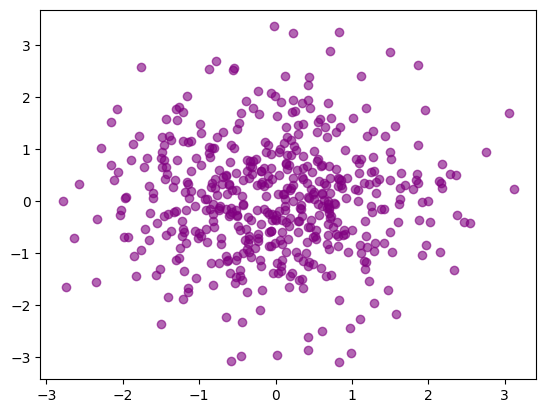

In [533]:
fig, axes = plt.subplots()
axes.scatter(*sample_pwise_reshaped, alpha = 0.6, color = "purple")

# **Gibbs measure in random environment**

In [707]:
def g(x, y) :

    return -jnp.log(jnp.linalg.norm(x-y)**2)

def V(x) :

    xnorm = jnp.linalg.norm(x)
    return -0.5 + 0.5* xnorm**2

**Sampling environmnent points**

In [708]:
key, _ = random.split(key, 2)
d = 2
N = 100
beta_N = N**2
env = gibbs(d, N, g, V, beta_N)
mvn = numpyro.distributions.MultivariateNormal(loc=jnp.zeros(d*N), covariance_matrix= jnp.eye(d*N))
start_sample_env = mvn.sample(key, (1, ))

In [709]:
sample_env = jit(vmap(partial(mala_tamed_pwise,
                                           N = N,
                                           d = d,
                                           log_prob_target = env.log_prob,
                                           n_iter = 1_000,
                                           step_size = 0.05)))(random.split(key, 1), start_sample_env)
sample_env_reshaped = sample_env.reshape(N, d)

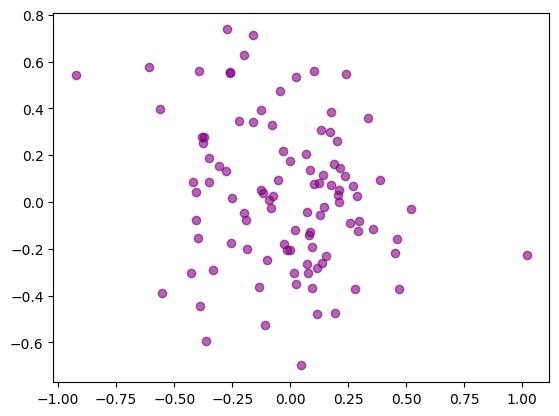

In [710]:
fig, axes = plt.subplots()
axes.scatter(*sample_env_reshaped.T, alpha = 0.6, color = "purple")

**Computing weights**

In [711]:
class unif(numpyro.distributions.Distribution) :

    def __init__(self, d, R) :

        self.d = d
        self.R = R
        event_shape = (self.d, )
        super(unif, self).__init__(event_shape = event_shape)

    def log_prob(self, value) :

        value_shape = value.shape
        logprob = self.d*jnp.log(self.R) + self.d/2 * jnp.log(jnp.pi) - jnp.log(scipy.special.gamma(1+self.d/2))
        outlier = jnp.linalg.norm(value) > self.R

        res = cond(outlier,
                   lambda _ : -jnp.inf,
                   lambda _ : logprob,
                   None)

        return res


In [712]:
mu_eq = unif(d, R = 1)
target = unif(d, R = 1/2)

In [713]:
def w(x) :

    return jnp.exp(target.log_prob(x) - mu_eq.log_prob(x))

In [714]:
w_env_unormalized = jnp.array([w(sample_env_reshaped[k, :]) for k in range(N)]) #takes some time...
w_env = w_env_unormalized / w_env_unormalized.sum()

In [718]:
def K(x, y, eps = 1e-5) :

    return - jnp.log(jnp.linalg.norm(x-y)**2 + eps**2)

def V_ext (x) :

    xnorm = jnp.linalg.norm(x)
    ext = xnorm > 1
    v = xnorm**2 - 1
    res = cond(ext,
               lambda _ : v,
               lambda _ : 0.,
               None)
    return res

def V_env(y) :

    x = sample_env_reshaped
    index = jnp.array([k for k in range(N)])
    kx = lambda j : w_env[j] * K(x[j, :], y, eps = N**(-1/d))
    v_inter = jit(kx)(index).sum()

    return V_ext(y) - v_inter


**Sampling the quenched Gibbs measure**

In [719]:
key, _ = random.split(key, 2)
quenched = gibbs(d, N, g, V_env, beta_N)
mvn = numpyro.distributions.MultivariateNormal(loc=jnp.zeros(d*N), covariance_matrix= jnp.eye(d*N))
start_sample_env = mvn.sample(key, (1, ))

In [720]:
sample_quenched = jit(vmap(partial(mala_tamed_pwise,
                                           N = N,
                                           d = d,
                                           log_prob_target = quenched.log_prob,
                                           n_iter = 1_000,
                                           step_size = 0.1)))(random.split(key, 1), start_sample_env)
sample_quenched_reshaped = sample_quenched.reshape(N, d)

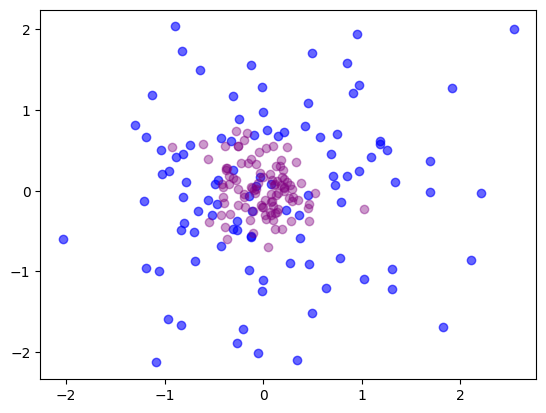

In [721]:
fig, axes = plt.subplots()
axes.scatter(*sample_quenched_reshaped.T, alpha = 0.6, color = "blue")
axes.scatter(*sample_env_reshaped.T, alpha = 0.4, color = "purple")